In [17]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# The Graphs in this Notebook
## 1. Varying Number of Reads Per Window
### Compares traditional, raw, and percent scoring
### Takeaway: traditional is bad, ~50 reads/window is pretty good
## 2. Varying Enrichment of Center Position
### Compares traditional, raw, and percent scoring
### Takeaway: traditional is bad, there is a wider error for depletion of center position
### Raw and Percent scoring are identical when you have the same number of reads in each window
## 3. Varying Enrichment of Center Position, Error as Difference
### No new insights
## 4. Varying Number of Windows
### Compares traditional, raw, and percent scoring
### Takeaway: About 200 windows is good
## 5. Fit a Distribution to windows in the Cerevisiae Dataset
### takeaway: Exponential distribution
## 6. Sampling from Distribution for Number of Reads and Varying Number of Windows
### Compares traditional, raw, and percent scoring
### Distribution does NOT generate really high read numbers, which is different from real data
### Takeaway:  percent scoring here is different than raw, worse
## 7. Trying a New Metric - normalization with SQRT(n), with sampling
## 8. Correction Score Distributions for Real Data
## 9. RRT for Corrected Real Data
## 10. Correlations between corrected and uncorrected data

In [459]:
%%capture captured
print('hi, stdout')
print('hi, stderr', file=sys.stderr)
#captured()

# 1. Varying Number of Reads Per Window
### Center Position Enriched 10x, 100 windows, 1000 Simulations 

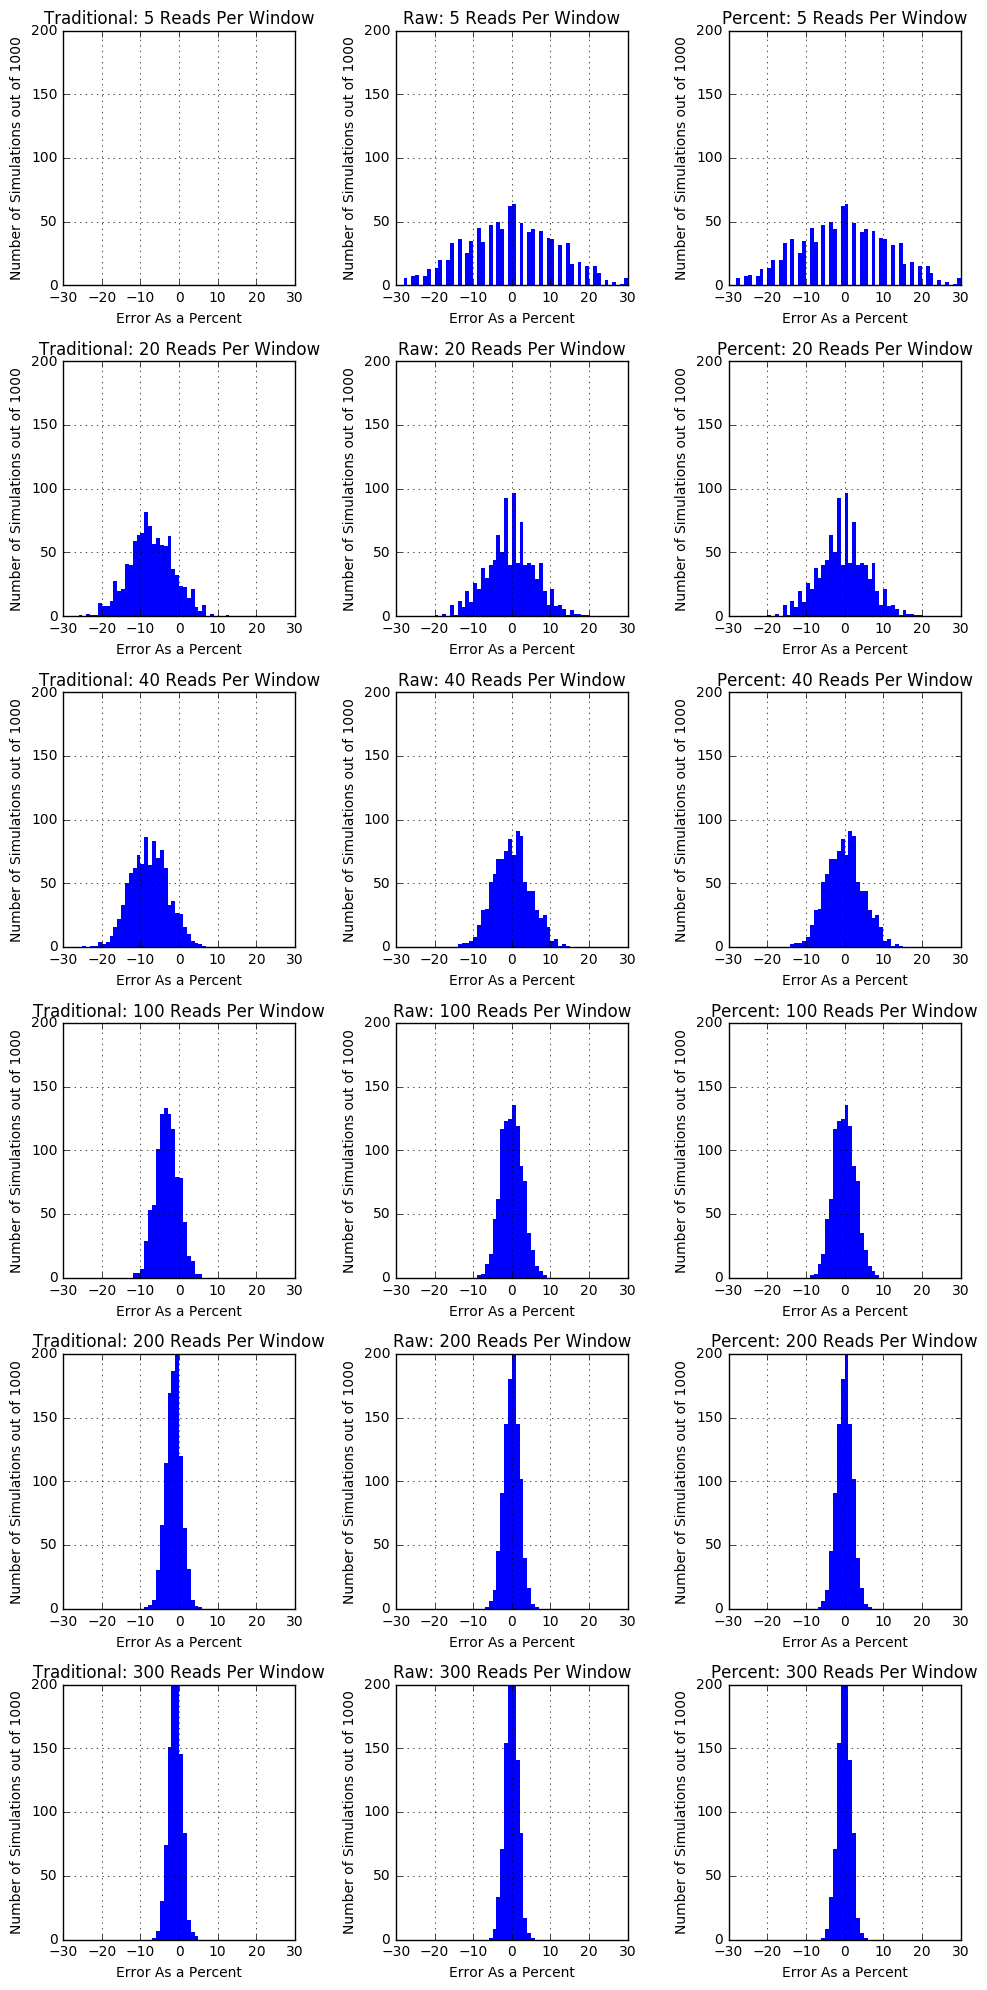

In [581]:
# testing the sensitivity to number of reads per window
# keep number of simulations, number of windows, and multiplicative factor of center position constant
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
start_time = time.time()
plt.figure(1, figsize=(10, 20))

counter = 0
for l in [5,20,40,100,200,300]:#range(5, 300, 50):
    counter += 1
    num_simulations = 100
    num_windows = 100
    num_reads = l
    increase_factor = 1
    sum_of_simulations_errors = 0
    chance_range = 6 + increase_factor
    simulations_array = []
    simulations_array_raw = []
    simulations_array_percent = []
    for k in range(0,num_simulations):
        num_skipped = 0
        sum_of_ratios = 0
        raw_buckets = [0] * 7
        sum_of_percents = 0
        for j in range(0,num_windows):
            buckets = [0] * 7
            for i in range(0,num_reads):
                x = random.randrange(0,chance_range)
                if (x > 5):
                    x = 6
                buckets[x] += 1
            # assign raw_reads
            for i in range(0,7):
                raw_buckets[i] += buckets[i]
            # for percent
            sum_of_percents += buckets[6]/float(num_reads)
            #print(buckets[6]/float(num_reads/100))
            #for i in range(0,6):
             #   print(buckets[i])
            #print(buckets[6])    
            avg_of_six = sum(buckets[:6]) / float(6)
            #print(avg_of_six)
            if avg_of_six == 0:
                num_skipped += 1
            else:
                ratio = buckets[6]/avg_of_six
                #print(ratio)
                if ratio == 0:
                    num_skipped += 1
                else:
                    sum_of_ratios += math.log(ratio)
        # calculate the traditional score
        all_windows_avg = math.exp(sum_of_ratios/float(num_windows - num_skipped))
        simulations_array.append((all_windows_avg - increase_factor)/float(increase_factor/100))
        # calculate the raw score
        raw_score = raw_buckets[6]/(sum(raw_buckets[:6]) / float(6))
        simulations_array_raw.append((raw_score - increase_factor)/float(increase_factor/100))
        # calculate the percent score
        percent_avg = (sum_of_percents/float(num_windows))
        percent_score = percent_avg/((1- percent_avg)/float(6))
        #print("percent_score %s"%(percent_score))
        #print((percent_score - increase_factor)/float(increase_factor/100))
        #print("\n")
        simulations_array_percent.append((percent_score - increase_factor)/float(increase_factor/100))
    # plot traditional score
    plt.subplot(6,3,counter)
    plt.ylim(0, 200)
    plt.hist(simulations_array, edgecolor='none', range=(-30,30), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Traditional: %s Reads Per Window' %(num_reads))
    plt.grid(True)
    counter +=1
    # plot raw score
    plt.subplot(6,3,counter)
    plt.ylim(0, 200)
    plt.hist(simulations_array_raw, edgecolor='none', range=(-30,30), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Raw: %s Reads Per Window' %(num_reads))
    plt.grid(True)
    counter +=1
    # plot percent score
    plt.subplot(6,3,counter)
    plt.ylim(0, 200)
    plt.hist(simulations_array_percent, edgecolor='none', range=(-30,30), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Percent: %s Reads Per Window' %(num_reads))
    plt.grid(True)
plt.tight_layout()    
#print("--- %s minutes ---" % ((time.time() - start_time)/60))

# 2. Varying Enrichment of Center Position
### 200 reads per window, 100 windows, 1000 Simulations 

* for greatly depleted center position (1/20), the distribution is shifted to positive (over-represented) for the traditional score, because of too many skipped windows when center is zero

* 
 

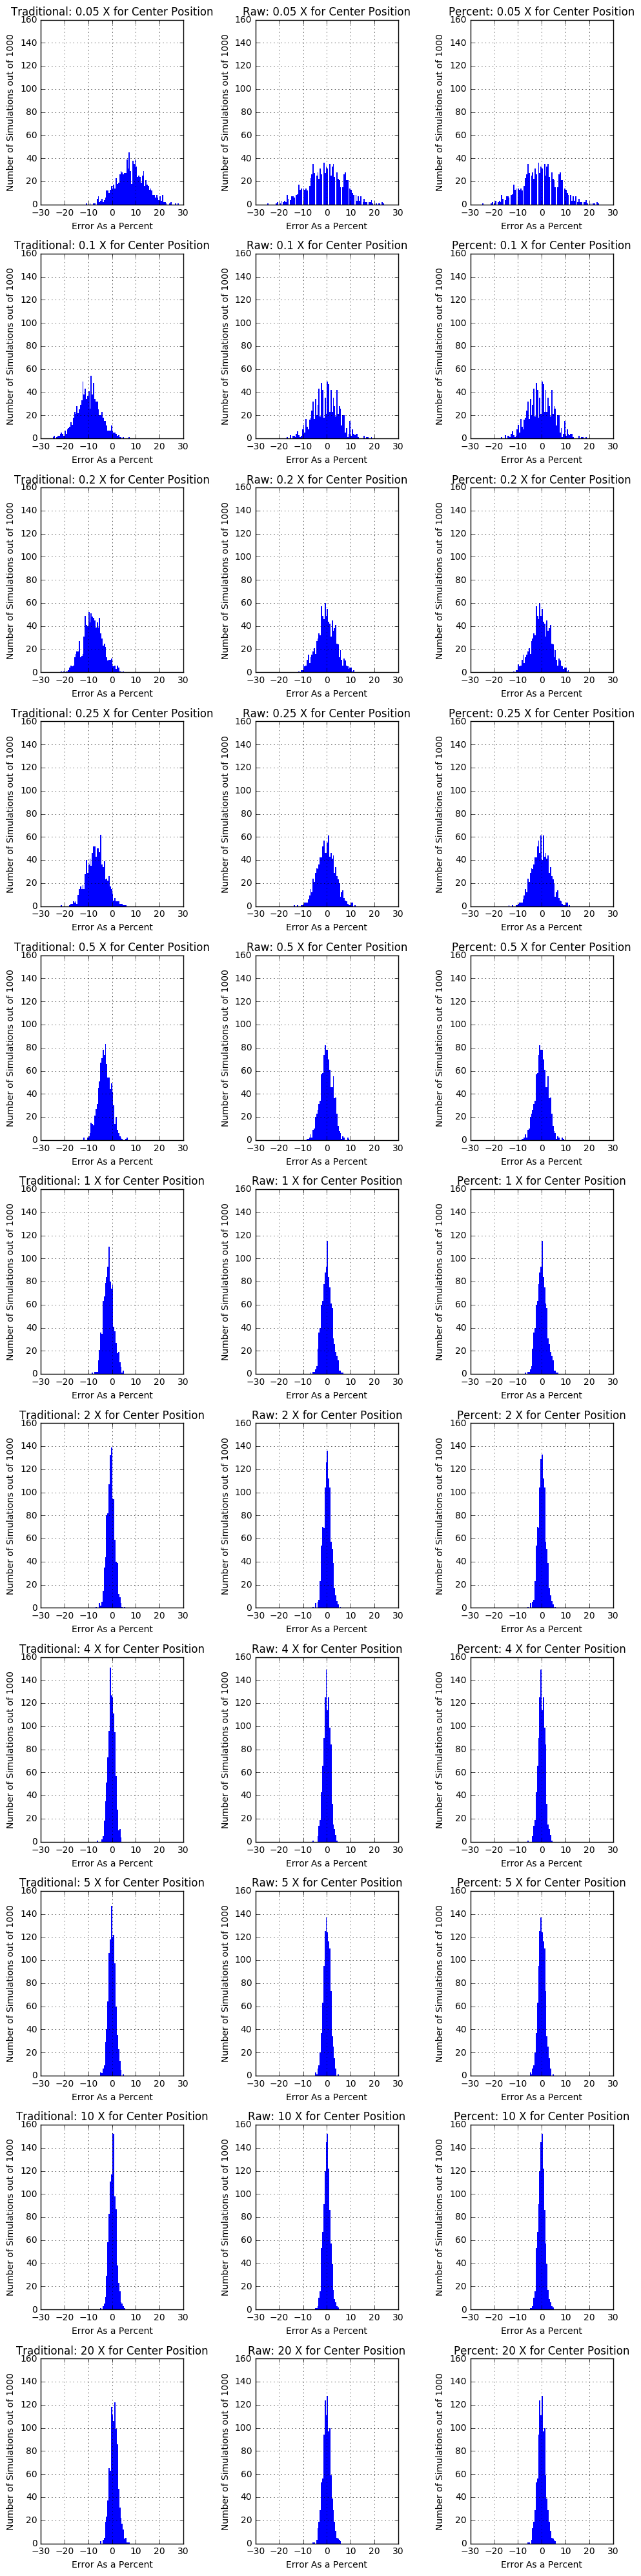

In [580]:
# testing the sensitivity to mulitplicative factor of center position 
# keep number of simulations, number of reads per window, and number of windows constant
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
start_time = time.time()
plt.figure(1, figsize=(10, 40))

counter = 0
for l in [1/20, 1/10, 1/5, 1/4, 1/2, 1,2,4,5,10,20]:
    counter += 1
    num_simulations = 1000
    num_windows = 100
    num_reads = 200
    increase_factor = l
    sum_of_simulations_errors = 0
    simulations_array = []
    simulations_array_raw = []
    simulations_array_percent = []
    chance_range = 6 + increase_factor
    #chance_range = 5*(6 + increase_factor)
    if (increase_factor < 1): 
        chance_range = 6*(1/increase_factor) + 1
    for k in range(0,num_simulations):
        num_skipped = 0
        sum_of_ratios = 0
        raw_buckets = [0] * 7
        sum_of_percents = 0
        for j in range(0,num_windows):
            buckets = [0] * 7
            for i in range(0,num_reads):
                x = random.randrange(0,chance_range)
                if (increase_factor < 1): 
                    if (x == (6*(1/increase_factor))): # final slot for the "center" position
                        x = 6
                    else:
                        x = x%6
                else:
                    if (x > 5): # all slots after the first 6 belong to the "center" position 
                        x = 6
                    # if (x > 29):
                    #    x = 6
                    #else:
                     #   x = x%6
                    
                buckets[x] += 1   
            # assign raw_reads
            for i in range(0,7):
                raw_buckets[i] += buckets[i]
            # for percent
            sum_of_percents += buckets[6]/float(num_reads)
            avg_of_six = sum(buckets[:6]) / float(6)
            if avg_of_six == 0:
                num_skipped += 1
            else:
                ratio = buckets[6]/avg_of_six
                #print(ratio)
                if ratio == 0:
                    num_skipped += 1
                else:
                    sum_of_ratios += math.log(ratio)
        # calculate the traditional score            
        all_windows_avg = math.exp(sum_of_ratios/float(num_windows - num_skipped))
        #print("factor %s, num_skipped %s, all_windows_avg %s"%(l,num_skipped, all_windows_avg))
        #print((all_windows_avg - increase_factor)/float(increase_factor/100))
        simulations_array.append((all_windows_avg - increase_factor)/float(increase_factor/100))
        # calculate the raw score
        raw_score = raw_buckets[6]/(sum(raw_buckets[:6]) / float(6))
        simulations_array_raw.append((raw_score - increase_factor)/float(increase_factor/100))
        #print("raw_score %s"%(raw_score))
        #print((raw_score - increase_factor)/float(increase_factor/100))
        # calculate the percent score
        percent_avg = (sum_of_percents/float(num_windows))
        percent_score = percent_avg/((1- percent_avg)/float(6))
        #print("percent_score %s"%(percent_score))
        #print((percent_score - increase_factor)/float(increase_factor/100))
        #print("\n")
        simulations_array_percent.append((percent_score - increase_factor)/float(increase_factor/100))
    # plot traditional score
    plt.subplot(11,3,counter)
    plt.ylim(0, 160)
    plt.hist(simulations_array, edgecolor='none', range=(-30,30), bins=120) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Traditional: %s X for Center Position' %(increase_factor))
    plt.grid(True)
    counter +=1
    # plot raw score
    plt.subplot(11,3,counter)
    plt.ylim(0, 160)
    plt.hist(simulations_array_raw, edgecolor='none', range=(-30,30), bins=120) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Raw: %s X for Center Position' %(increase_factor))
    plt.grid(True)
    counter +=1
    # plot percent score
    plt.subplot(11,3,counter)
    plt.ylim(0, 160)
    plt.hist(simulations_array_percent, edgecolor='none', range=(-30,30), bins=120) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Percent: %s X for Center Position' %(increase_factor))
    plt.grid(True)    
plt.tight_layout()    
#print("--- %s minutes ---" % ((time.time() - start_time)/60))

# 3. And now test the error as a difference

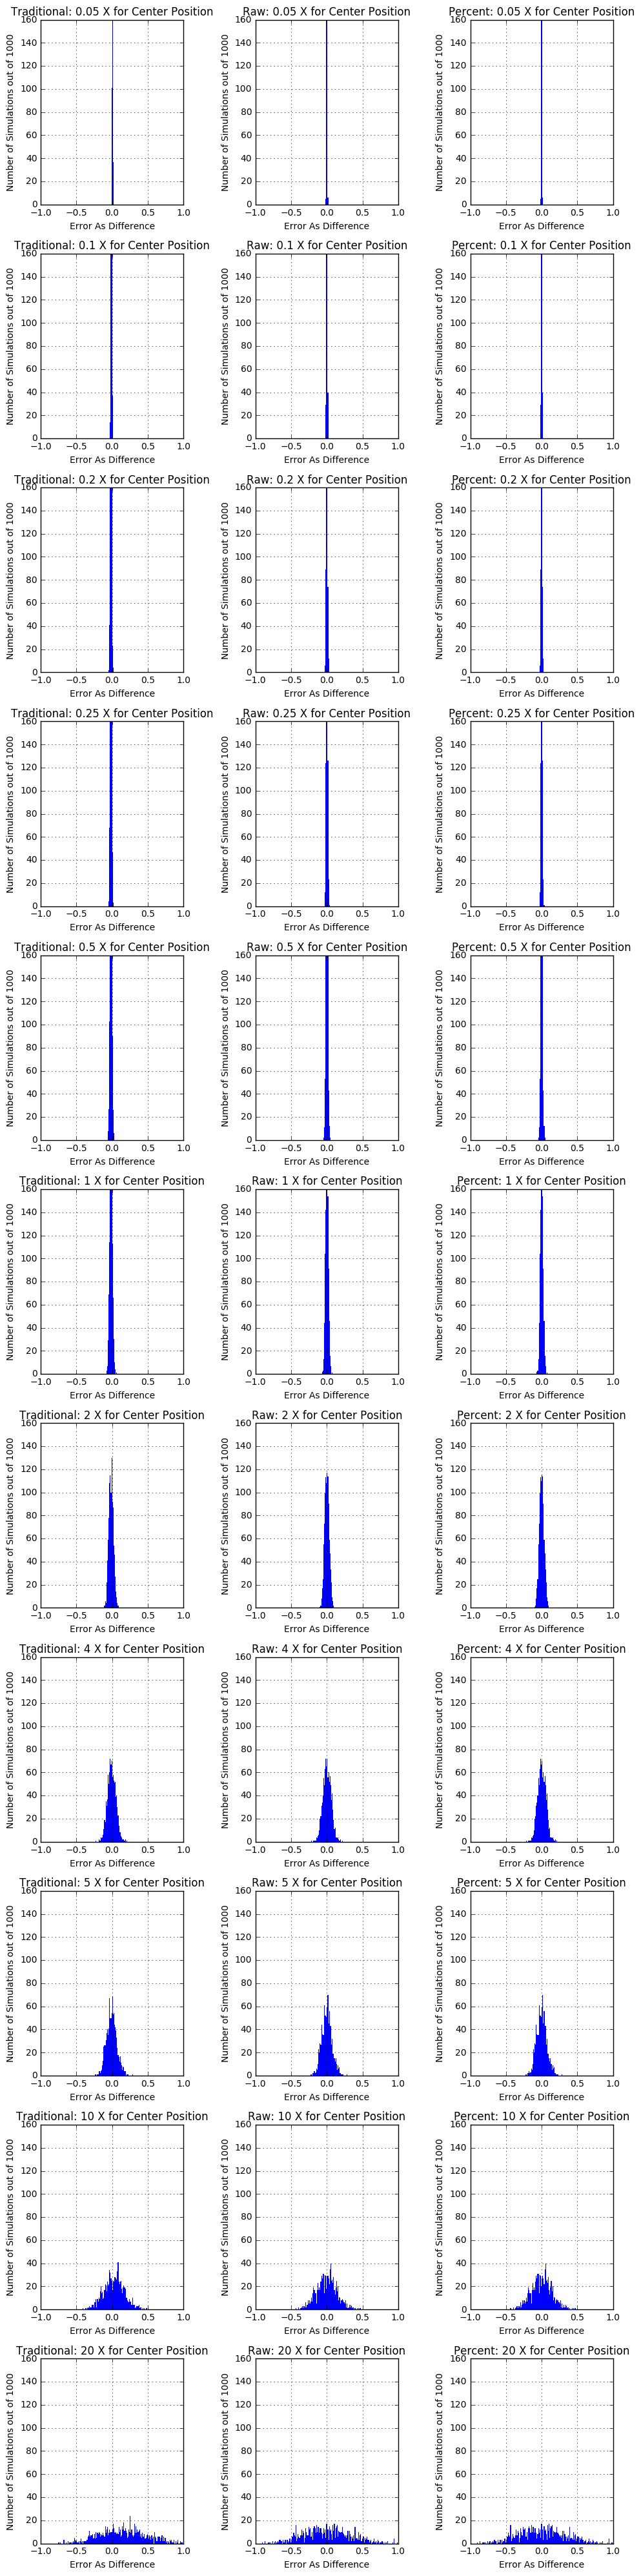

In [736]:
# testing the sensitivity to mulitplicative factor of center position 
# keep number of simulations, number of reads per window, and number of windows constant
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
start_time = time.time()
plt.figure(1, figsize=(10, 40))

counter = 0
for l in [1/20, 1/10, 1/5, 1/4, 1/2, 1,2,4,5,10,20]:
    counter += 1
    num_simulations = 1000
    num_windows = 100
    num_reads = 200
    increase_factor = l
    sum_of_simulations_errors = 0
    simulations_array = []
    simulations_array_raw = []
    simulations_array_percent = []
    chance_range = 6 + increase_factor
    #chance_range = 5*(6 + increase_factor)
    if (increase_factor < 1): 
        chance_range = 6*(1/increase_factor) + 1
    for k in range(0,num_simulations):
        num_skipped = 0
        sum_of_ratios = 0
        raw_buckets = [0] * 7
        sum_of_percents = 0
        for j in range(0,num_windows):
            buckets = [0] * 7
            for i in range(0,num_reads):
                x = random.randrange(0,chance_range)
                if (increase_factor < 1): 
                    if (x == (6*(1/increase_factor))): # final slot for the "center" position
                        x = 6
                    else:
                        x = x%6
                else:
                    if (x > 5): # all slots after the first 6 belong to the "center" position 
                        x = 6
                    # if (x > 29):
                    #    x = 6
                    #else:
                     #   x = x%6
                    
                buckets[x] += 1   
            # assign raw_reads
            for i in range(0,7):
                raw_buckets[i] += buckets[i]
            # for percent
            sum_of_percents += buckets[6]/float(num_reads)
            avg_of_six = sum(buckets[:6]) / float(6)
            if avg_of_six == 0:
                num_skipped += 1
            else:
                ratio = buckets[6]/avg_of_six
                #print(ratio)
                if ratio == 0:
                    num_skipped += 1
                else:
                    sum_of_ratios += math.log(ratio)
        # calculate the traditional score            
        all_windows_avg = math.exp(sum_of_ratios/float(num_windows - num_skipped))
        #print("factor %s, num_skipped %s, all_windows_avg %s"%(l,num_skipped, all_windows_avg))
        #print((all_windows_avg - increase_factor)/float(increase_factor/100))
        simulations_array.append(all_windows_avg - increase_factor)
        # calculate the raw score
        raw_score = raw_buckets[6]/(sum(raw_buckets[:6]) / float(6))
        simulations_array_raw.append(raw_score - increase_factor)
        #print("raw_score %s"%(raw_score))
        #print((raw_score - increase_factor)/float(increase_factor/100))
        # calculate the percent score
        percent_avg = (sum_of_percents/float(num_windows))
        percent_score = percent_avg/((1- percent_avg)/float(6))
        #print("percent_score %s"%(percent_score))
        #print((percent_score - increase_factor)/float(increase_factor/100))
        #print("\n")
        simulations_array_percent.append(percent_score - increase_factor)
    # plot traditional score
    plt.subplot(11,3,counter)
    plt.ylim(0, 160)
    plt.hist(simulations_array, edgecolor='none', range=(-1,1), bins=200) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As Difference')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Traditional: %s X for Center Position' %(increase_factor))
    plt.grid(True)
    counter +=1
    # plot raw score
    plt.subplot(11,3,counter)
    plt.ylim(0, 160)
    plt.hist(simulations_array_raw, edgecolor='none', range=(-1,1), bins=200) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As Difference')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Raw: %s X for Center Position' %(increase_factor))
    plt.grid(True)
    counter +=1
    # plot percent score
    plt.subplot(11,3,counter)
    plt.ylim(0, 160)
    plt.hist(simulations_array_percent, edgecolor='none', range=(-1,1), bins=200) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As Difference')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Percent: %s X for Center Position' %(increase_factor))
    plt.grid(True)    
plt.tight_layout()    
#print("--- %s minutes ---" % ((time.time() - start_time)/60))

# 4. Varying Number of Windows
### Center Position Enriched 10x, 100 reads per window, 1000 Simulations 

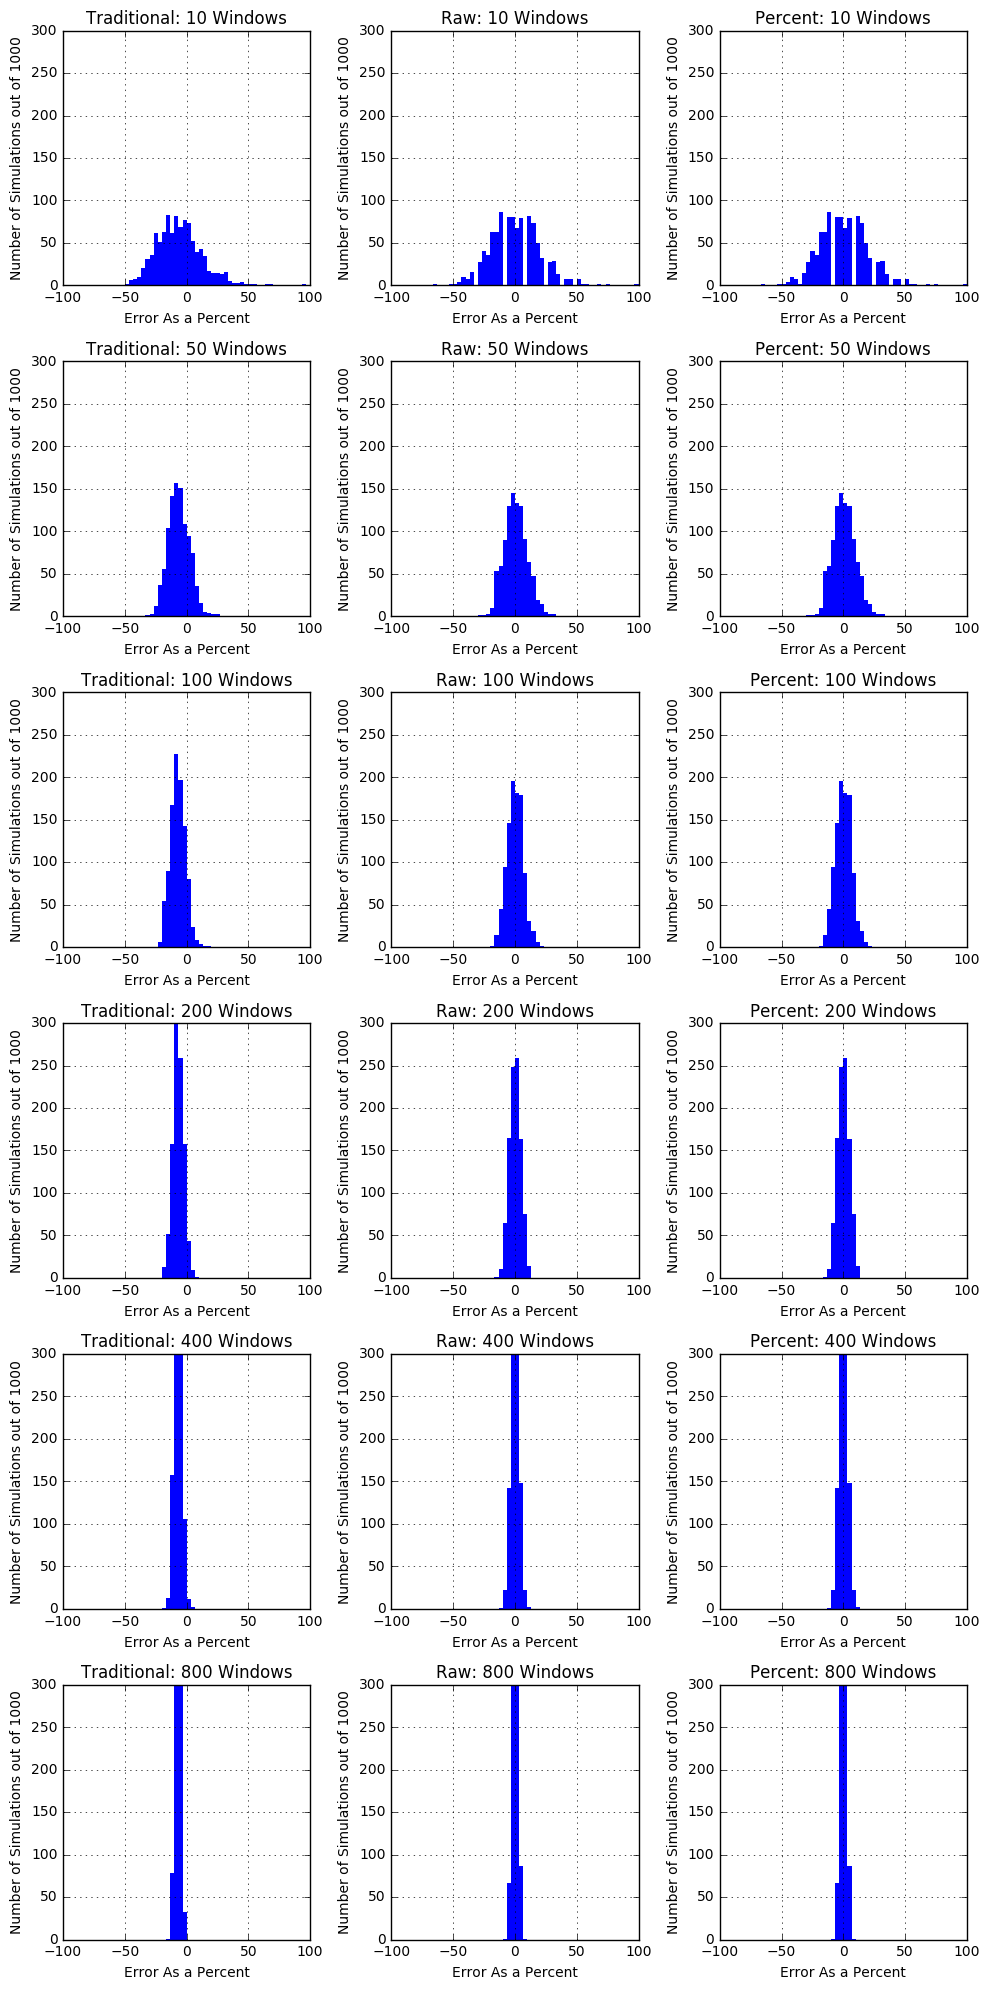

In [595]:
# testing the sensitivity to number of windows
# keep number of simulations, number of  reads per window, and multiplicative factor of center position constant
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
start_time = time.time()
plt.figure(1, figsize=(10, 20))

counter = 0
for l in [10,50,100,200,400,800]:
    counter += 1
    num_simulations = 1000
    num_windows = l
    num_reads = 20
    increase_factor = 1
    sum_of_simulations_errors = 0
    chance_range = 6 + increase_factor
    simulations_array = []
    simulations_array_raw = []
    simulations_array_percent = []
    for k in range(0,num_simulations):
        num_skipped = 0
        sum_of_ratios = 0
        raw_buckets = [0] * 7
        sum_of_percents = 0
        for j in range(0,num_windows):
            buckets = [0] * 7
            for i in range(0,num_reads):
                x = random.randrange(0,chance_range)
                if (x > 5):
                    x = 6
                buckets[x] += 1
            # assign raw_reads
            for i in range(0,7):
                raw_buckets[i] += buckets[i]
            # for percent
            sum_of_percents += buckets[6]/float(num_reads)
            #for i in range(0,6):
             #   print(buckets[i])
            #print(buckets[6])    
            avg_of_six = sum(buckets[:6]) / float(6)
            #print(avg_of_six)
            if avg_of_six == 0:
                num_skipped += 1
            else:
                ratio = buckets[6]/avg_of_six
                #print(ratio)
                if ratio == 0:
                    num_skipped += 1
                else:
                    sum_of_ratios += math.log(ratio)
        # calculate the traditional score
        all_windows_avg = math.exp(sum_of_ratios/float(num_windows - num_skipped))
        simulations_array.append((all_windows_avg - increase_factor)/float(increase_factor/100))
        # calculate the raw score
        raw_score = raw_buckets[6]/(sum(raw_buckets[:6]) / float(6))
        simulations_array_raw.append((raw_score - increase_factor)/float(increase_factor/100))
        # calculate the percent score
        percent_avg = (sum_of_percents/float(num_windows))
        percent_score = percent_avg/((1 - percent_avg)/float(6))
        #print("percent_score %s"%(percent_score))
        #print((percent_score - increase_factor)/float(increase_factor/100))
        #print("\n")
        simulations_array_percent.append((percent_score - increase_factor)/float(increase_factor/100))
    plt.grid(True)
    # plot traditional score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array, edgecolor='none', range=(-100,100), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Traditional: %s Windows' %(num_windows))
    plt.grid(True)
    counter +=1
    # plot raw score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array_raw, edgecolor='none', range=(-100,100), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Raw: %s Windows' %(num_windows))
    plt.grid(True)
    counter +=1
    # plot percent score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array_percent, edgecolor='none', range=(-100,100), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Percent: %s Windows' %(num_windows))
    plt.grid(True)    
plt.tight_layout()    
#print("--- %s minutes ---" % ((time.time() - start_time)/60))

# 5. Fit a Distribution to windows in the Cerevisiae Dataset
## each value is the number of reads in a window with AAA in the middle

[ 9.71149927]
--- 0.023229352633158364 minutes ---


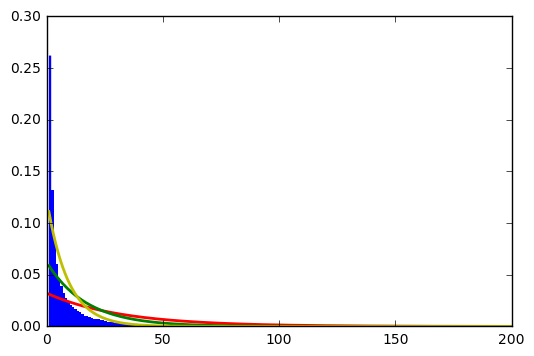

In [765]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import expon
import time
start_time = time.time()

s = np.random.normal(20, 10.0, 100)
with open("scores.txt") as f:
    content = f.readlines()
content = [x.strip('\n') for x in content]
content = list(map(int, content))

plt.hist(content, normed = 'true', range=(1,200), bins=200, edgecolor='none')
#params = expon.fit(content)
#print(params)
x = np.linspace(1, 200, 200)
pdf = expon.pdf(x, 1, 32)
plt.plot(x, pdf, 'r-', linewidth=2)
pdf = expon.pdf(x, 1, 17)
plt.plot(x, pdf, 'g-', linewidth=2)
pdf = expon.pdf(x, 1, 9)
plt.plot(x, pdf, 'y-', linewidth=2)
r = expon.rvs(1,17,1000)
r = expon.rvs(1,17,1)
print(r)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

# 6. Sampling from Distribution for Number of Reads and Varying Number of Windows

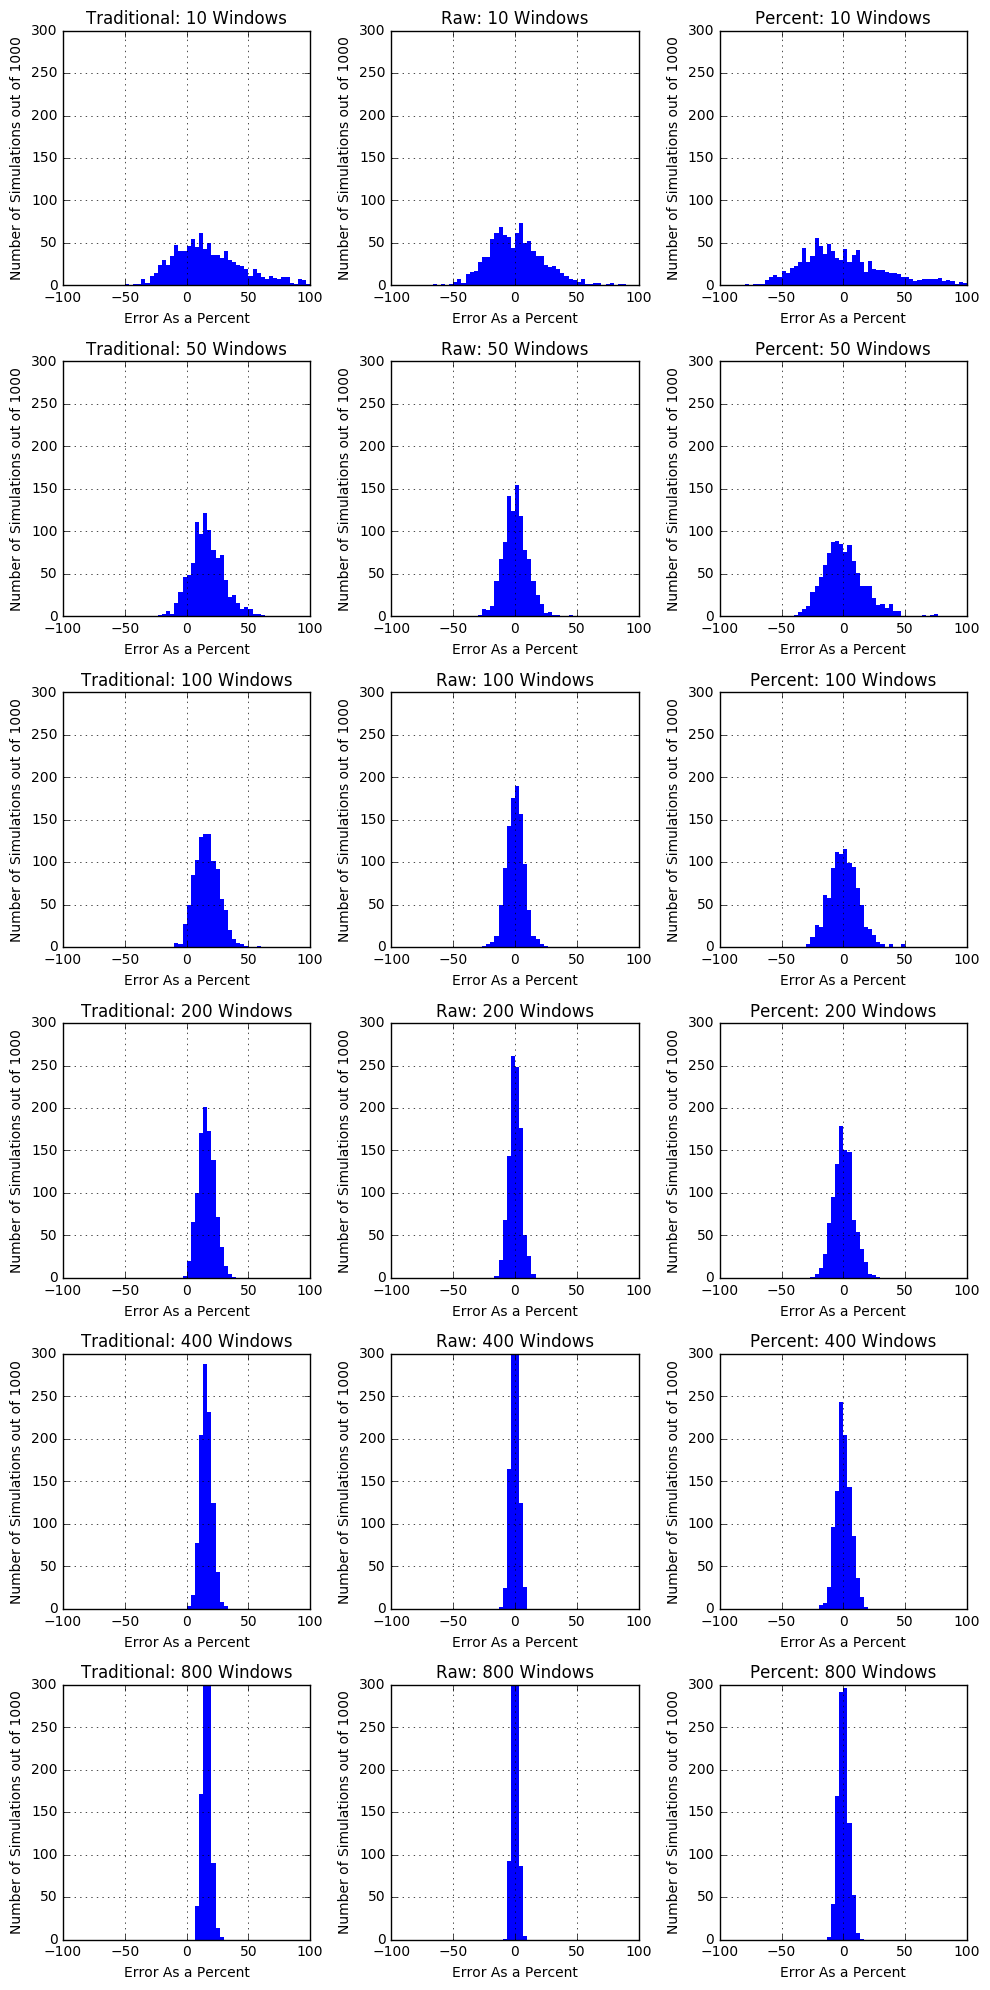

In [767]:
# testing the sensitivity to number of reads per window
# keep number of simulations, number of windows, and multiplicative factor of center position constant
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
start_time = time.time()
from scipy.stats import expon
plt.figure(1, figsize=(10, 20))

counter = 0

for l in [10,50,100,200,400,800]:
    counter += 1
    num_simulations = 1000
    num_windows = l
    increase_factor = 1
    sum_of_simulations_errors = 0
    chance_range = 6 + increase_factor
    simulations_array = []
    simulations_array_raw = []
    simulations_array_percent = []
    for k in range(0,num_simulations):
        num_skipped = 0
        sum_of_ratios = 0
        raw_buckets = [0] * 7
        sum_of_percents = 0
        for j in range(0,num_windows):
            buckets = [0] * 7
            num_reads = int(expon.rvs(1,17,1)) # get the number of reads from a distribution
            for i in range(0,num_reads):
                x = random.randrange(0,chance_range)
                if (x > 5):
                    x = 6
                buckets[x] += 1
            # assign raw_reads
            for i in range(0,7):
                raw_buckets[i] += buckets[i]
            # for percent
            sum_of_percents += buckets[6]/float(num_reads)
            #for i in range(0,6):
             #   print(buckets[i])
            #print(buckets[6])    
            avg_of_six = sum(buckets[:6]) / float(6)
            #print(avg_of_six)
            if avg_of_six == 0:
                num_skipped += 1
            else:
                ratio = buckets[6]/avg_of_six
                #print(ratio)
                if ratio == 0:
                    num_skipped += 1
                else:
                    sum_of_ratios += math.log(ratio)
        # calculate the traditional score
        all_windows_avg = math.exp(sum_of_ratios/float(num_windows - num_skipped))
        simulations_array.append((all_windows_avg - increase_factor)/float(increase_factor/100))
        # calculate the raw score
        raw_score = raw_buckets[6]/(sum(raw_buckets[:6]) / float(6))
        simulations_array_raw.append((raw_score - increase_factor)/float(increase_factor/100))
        # calculate the percent score
        percent_avg = (sum_of_percents/float(num_windows))
        percent_score = percent_avg/((1 - percent_avg)/float(6))
        #print("percent_score %s"%(percent_score))
        #print((percent_score - increase_factor)/float(increase_factor/100))
        #print("\n")
        simulations_array_percent.append((percent_score - increase_factor)/float(increase_factor/100))
    plt.grid(True)
    # plot traditional score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array, edgecolor='none', range=(-100,100), bins=60)
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Traditional: %s Windows' %(num_windows))
    plt.grid(True)
    counter +=1
    # plot raw score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array_raw, edgecolor='none', range=(-100,100), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Raw: %s Windows' %(num_windows))
    plt.grid(True)
    counter +=1
    # plot percent score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array_percent, edgecolor='none', range=(-100,100), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Percent: %s Windows' %(num_windows))
    plt.grid(True)    
plt.tight_layout()    
#print("--- %s minutes ---" % ((time.time() - start_time)/60))


# 7. Trying a New Metric - normalization with SQRT(n), with sampling

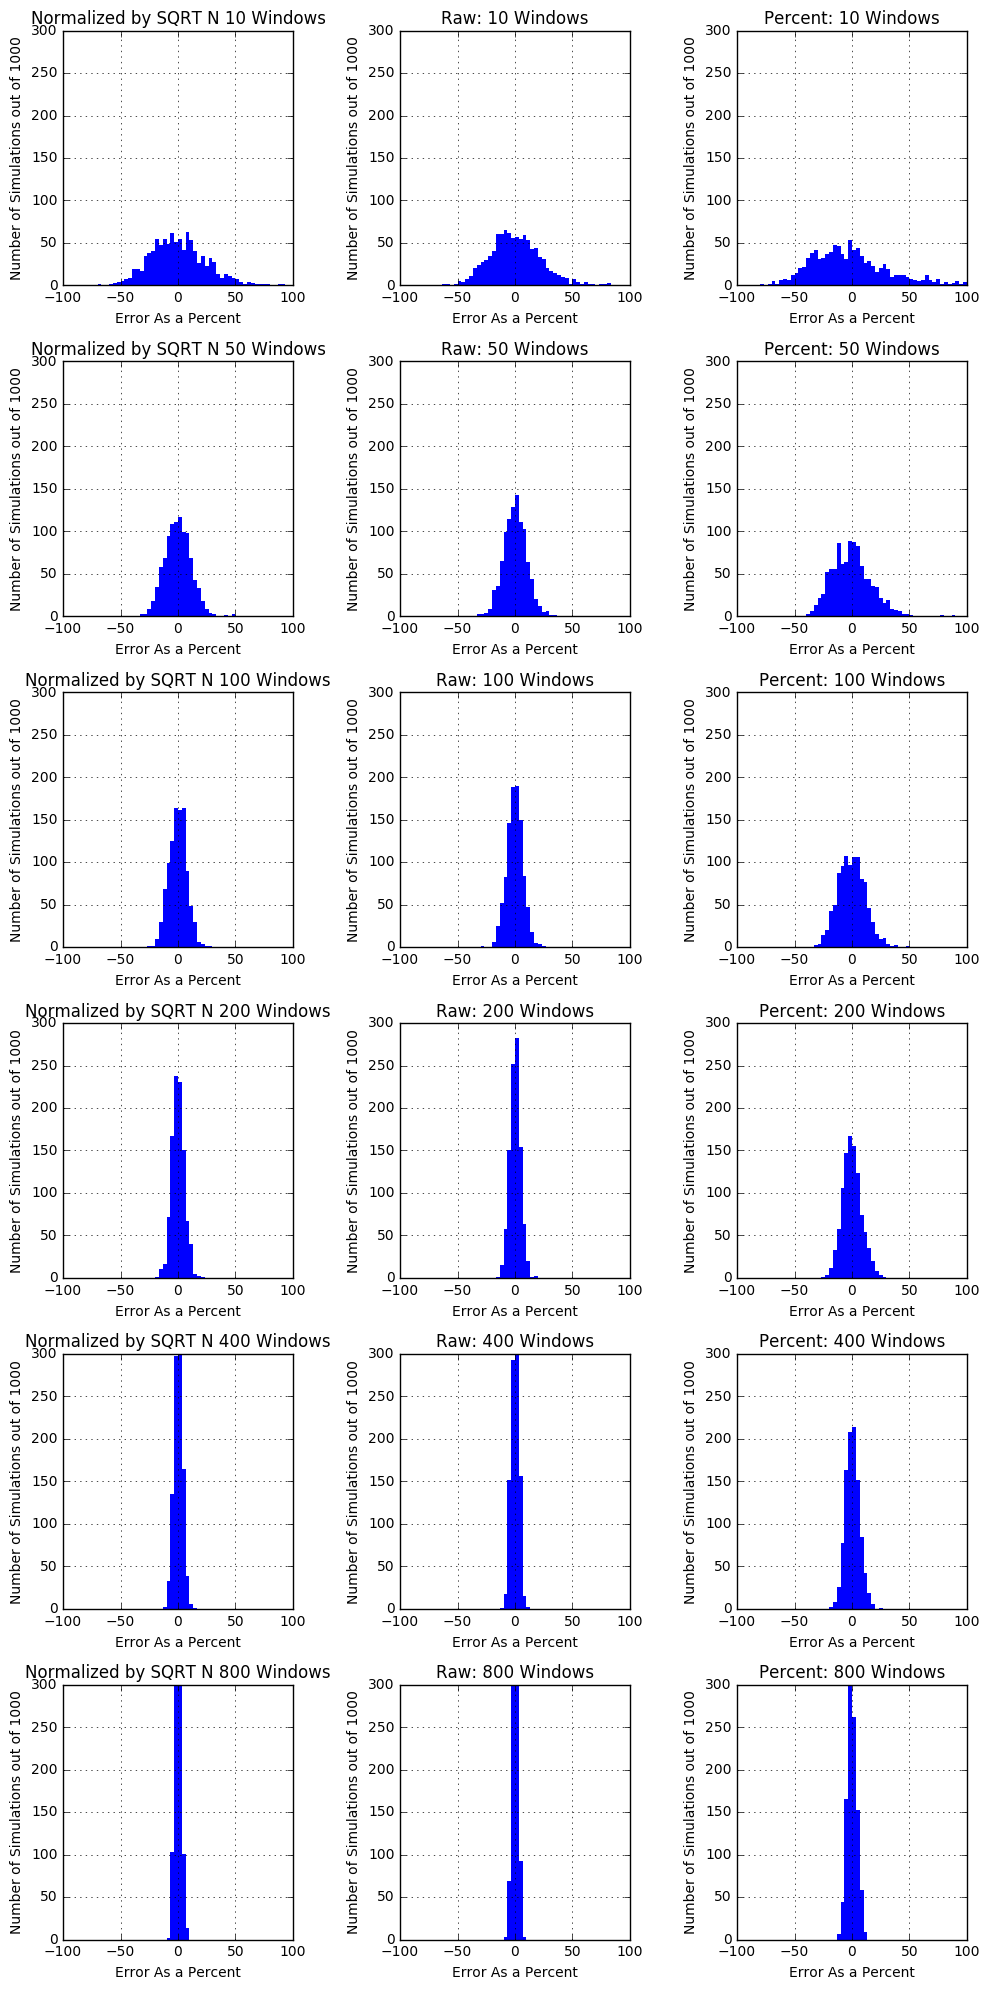

In [773]:
# testing the sensitivity to number of reads per window
# keep number of simulations, number of windows, and multiplicative factor of center position constant
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
start_time = time.time()
from scipy.stats import expon
plt.figure(1, figsize=(10, 20))

counter = 0

for l in [10,50,100,200,400,800]:
    counter += 1
    num_simulations = 1000
    num_windows = l
    increase_factor = 1
    sum_of_simulations_errors = 0
    chance_range = 6 + increase_factor
    simulations_array_normalized = []
    simulations_array_raw = []
    simulations_array_percent = []
    for k in range(0,num_simulations):
        raw_buckets = [0] * 7
        normalized_buckets = [0] * 7
        sum_of_percents = 0
        for j in range(0,num_windows):
            buckets = [0] * 7
            num_reads = int(expon.rvs(1,17,1)) # get the number of reads from a distribution
            for i in range(0,num_reads):
                x = random.randrange(0,chance_range)
                if (x > 5):
                    x = 6
                buckets[x] += 1
            # assign raw_buckets
            for i in range(0,7):
                raw_buckets[i] += buckets[i]
            # assign normalized_buckets
            window_sum = sum(buckets)
            for i in range(0,7):
                normalized_buckets[i] += math.sqrt(window_sum)*(buckets[i]/window_sum)
            # for percent
            sum_of_percents += buckets[6]/float(num_reads)    
        # calculate the raw score
        raw_score = raw_buckets[6]/(sum(raw_buckets[:6]) / float(6))
        simulations_array_raw.append((raw_score - increase_factor)/float(increase_factor/100))
        # calculate the normalized score
        normalized_score = normalized_buckets[6]/(sum(normalized_buckets[:6]) / float(6)) 
        simulations_array_normalized.append((normalized_score - increase_factor)/float(increase_factor/100))
        # calculate the percent score
        percent_avg = (sum_of_percents/float(num_windows))
        percent_score = percent_avg/((1 - percent_avg)/float(6))
        simulations_array_percent.append((percent_score - increase_factor)/float(increase_factor/100))
    plt.grid(True)
    # plot traditional score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array_normalized, edgecolor='none', range=(-100,100), bins=60)
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Normalized by SQRT N %s Windows' %(num_windows))
    plt.grid(True)
    counter +=1
    # plot raw score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array_raw, edgecolor='none', range=(-100,100), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Raw: %s Windows' %(num_windows))
    plt.grid(True)
    counter +=1
    # plot percent score
    plt.subplot(6,3,counter)
    plt.ylim(0, 300)
    plt.hist(simulations_array_percent, edgecolor='none', range=(-100,100), bins=60) #, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xlabel('Error As a Percent')
    plt.ylabel('Number of Simulations out of 1000')
    plt.title('Percent: %s Windows' %(num_windows))
    plt.grid(True)    
plt.tight_layout()    
#print("--- %s minutes ---" % ((time.time() - start_time)/60))

## 8. Correction Score Distributions for Real Data

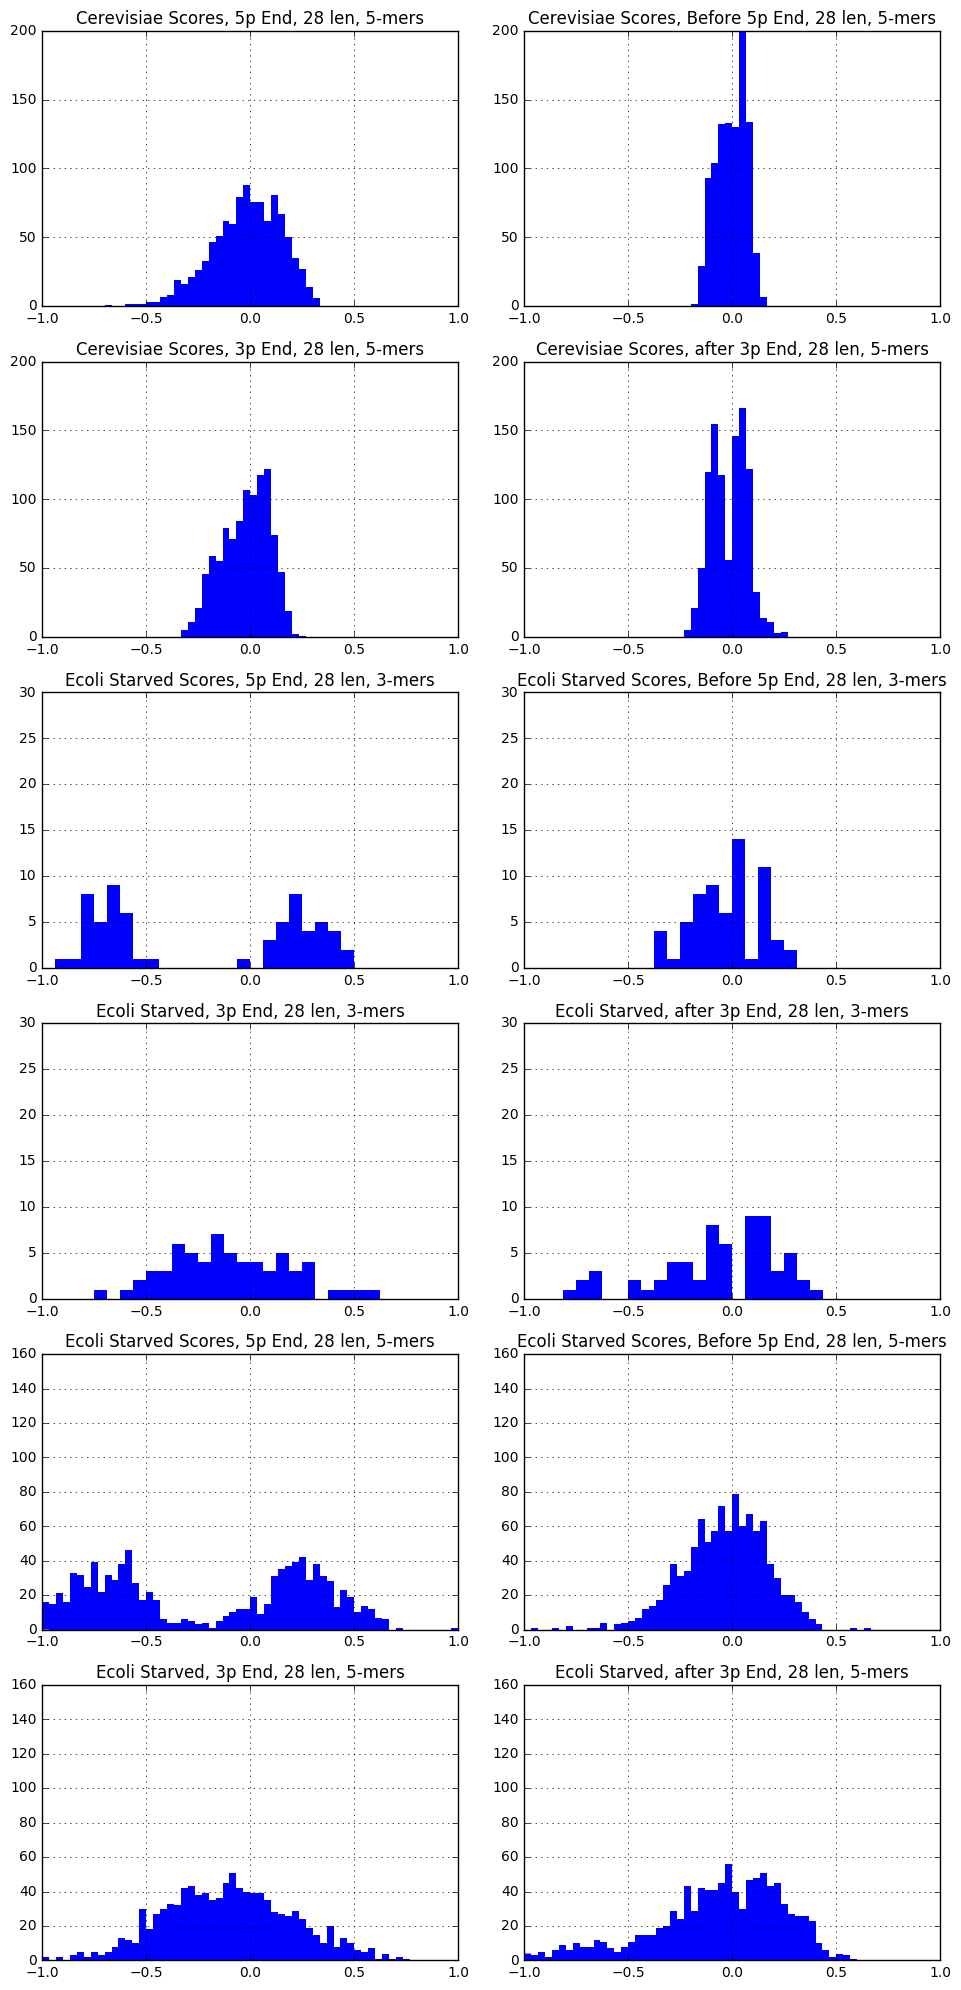

In [921]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import expon
import numpy as np
import time
start_time = time.time()
plt.figure(1, figsize=(10, 20))

# cerevisiae 

plt.subplot(6,2,1)
plt.title('Cerevisiae Scores, 5p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 200)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_cerevisiae_28_5_5.csv")
content = df['score']
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, bins=60, range=(-1,1), edgecolor='none');

plt.subplot(6,2,2)
plt.title('Cerevisiae Scores, Before 5p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 200)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_cerevisiae_28_before5_5.csv")
content = df['score']
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, bins=60, range=(-1,1), edgecolor='none');

plt.subplot(6,2,3)
plt.title('Cerevisiae Scores, 3p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 200)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_cerevisiae_28_3_5.csv")
content = df.score
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, bins=60, range=(-1,1), edgecolor='none');

plt.subplot(6,2,4)
plt.title('Cerevisiae Scores, after 3p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 200)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_cerevisiae_28_after3_5.csv")
content = df.score
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, bins=60, range=(-1,1), edgecolor='none');

# ecoli starved 3-mers

plt.subplot(6,2,5)
plt.title('Ecoli Starved Scores, 5p End, 28 len, 3-mers')
plt.grid(True)
plt.ylim(0.0, 30)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_5_3.csv")
content = df['score']
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=32);

plt.subplot(6,2,6)
plt.title('Ecoli Starved Scores, Before 5p End, 28 len, 3-mers')
plt.grid(True)
plt.ylim(0.0, 30)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_before5_3.csv")
content = df['score']
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=32);

plt.subplot(6,2,7)
plt.title('Ecoli Starved, 3p End, 28 len, 3-mers')
plt.grid(True)
plt.ylim(0.0, 30)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_3_3.csv")
content = df.score
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=32);

plt.subplot(6,2,8)
plt.title('Ecoli Starved, after 3p End, 28 len, 3-mers')
plt.grid(True)
plt.ylim(0.0, 30)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_after3_3.csv")
content = df.score
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=32);

# ecoli starved 5-mer

plt.subplot(6,2,9)
plt.title('Ecoli Starved Scores, 5p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 160)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_5_5.csv")
content = df['score']
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=60);

plt.subplot(6,2,10)
plt.title('Ecoli Starved Scores, Before 5p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 160)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_before5_5.csv")
content = df['score']
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=60);

plt.subplot(6,2,11)
plt.title('Ecoli Starved, 3p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 160)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_3_5.csv")
content = df.score
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=60);

plt.subplot(6,2,12)
plt.title('Ecoli Starved, after 3p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 160)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_ecoli_starved_28_after3_5.csv")
content = df.score
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, edgecolor='none', range=(-1,1), bins=60);

plt.tight_layout()

## 9. RRT for Corrected Real Data

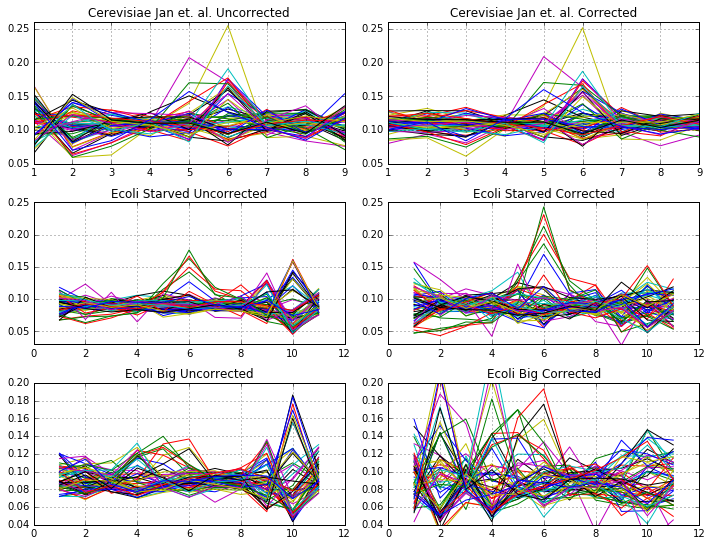

In [16]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(1, figsize=(10, 10))

plt.subplot(4,2,1)
plt.ylim(0.05, 0.26)
plt.title('Cerevisiae Jan et. al. Uncorrected')
plt.grid(True)
csvfile = open('window_stage2_cerevisiae_28.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:10]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9],row)

plt.subplot(4,2,2)
plt.ylim(0.05, 0.26)
plt.title('Cerevisiae Jan et. al. Corrected')
plt.grid(True)
csvfile = open('window_stage2_v6_all_jan_corrected.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:10]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9],row)
    
    
plt.subplot(4,2,3)
plt.ylim(0.03, 0.25)
plt.title('Ecoli Starved Uncorrected')
plt.grid(True)
csvfile = open('window_stage2_ecoli_starved_justin.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:12]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9,10,11],row)    
    
plt.subplot(4,2,4)
plt.ylim(0.03, 0.25)
plt.title('Ecoli Starved Corrected')
plt.grid(True)
csvfile = open('window_stage2_ec_starved_v6.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:12]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9,10,11],row) 
    
plt.subplot(4,2,5)
plt.ylim(0.04, 0.2)
plt.title('Ecoli Big Uncorrected')
plt.grid(True)
csvfile = open('window_stage2_ecoli_big_justin.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:12]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9,10,11],row)   
    
plt.subplot(4,2,6)
plt.ylim(0.04, 0.2)
plt.title('Ecoli Big Corrected')
plt.grid(True)
csvfile = open('window_stage2_ecoli_big_corrected_v6_only28.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:12]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9,10,11],row)    
    
plt.tight_layout()


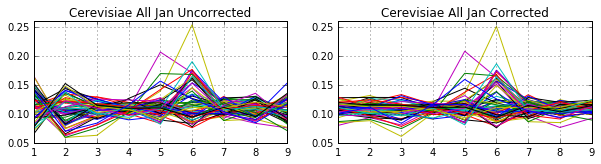

In [10]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(1, figsize=(10, 10))

plt.subplot(4,2,1)
plt.ylim(0.05, 0.26)
plt.title('Cerevisiae All Jan Uncorrected')
plt.grid(True)
csvfile = open('window_stage2_cerevisiae_28.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:10]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9],row)

plt.subplot(4,2,2)
plt.ylim(0.05, 0.26)
plt.title('Cerevisiae All Jan Corrected')
plt.grid(True)
csvfile = open('window_stage2_v6_all_jan_corrected.csv')
reader = csv.reader(csvfile, delimiter=',')
for row in reader:
    tag = row[0]
    row = row[1:10]
    row = [x.strip('\n') for x in row]
    row = list(map(float, row))
    plt.plot([1,2,3,4,5,6,7,8,9],row)
    

## 10. Correlations between corrected and uncorrected data

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd
import scipy.stats as stats
start_time = time.time()
from IPython.display import display
pd.set_option('display.notebook_repr_html', True)

# cerevisiae 
df = pd.read_csv("window_stage2_cerevisiae_28.csv",header=None)
df_corrected = pd.read_csv("window_stage2_v6_all_jan_corrected.csv",header=None)
c_pearson = []
c_spearman = []
for i in range(1,12):
    if i > 9:
        c_spearman.append(0)
        c_pearson.append(0)
    else:
        rho, pval = stats.spearmanr(df[i],df_corrected[i])
        c_spearman.append(rho)
        rho, pval = stats.pearsonr(df[i],df_corrected[i])
        c_pearson.append(rho)

# ecoli starved
df = pd.read_csv("window_stage2_ecoli_starved_justin.csv",header=None)
df_corrected = pd.read_csv("window_stage2_ec_starved_v6.csv",header=None)
es_pearson = []
es_spearman = []
for i in range(1,12):
    rho, pval = stats.spearmanr(df[i],df_corrected[i])
    es_spearman.append(rho)
    rho, pval = stats.pearsonr(df[i],df_corrected[i])
    es_pearson.append(rho)
    
# ecoli starved
df = pd.read_csv("window_stage2_ecoli_big_justin.csv",header=None)
df_corrected = pd.read_csv("window_stage2_ecoli_big_corrected_v6.csv",header=None)
eb_pearson = []
eb_spearman = []
for i in range(1,12):
    rho, pval = stats.spearmanr(df[i],df_corrected[i])
    eb_spearman.append(rho)
    rho, pval = stats.pearsonr(df[i],df_corrected[i])
    eb_pearson.append(rho)    

data = {'cerevisiae_spearman': c_spearman,
        'cerevisiae_pearson': c_pearson,
        'ecoli_starv_spearman': es_spearman,
        'ecoli_starv_pearson': es_pearson,
        'ecoli_big_spearman': eb_spearman,
        'ecoli_big_pearson': eb_pearson
        }
table = pd.DataFrame(data, columns=['cerevisiae_spearman', 'cerevisiae_pearson', 'ecoli_starv_spearman', 'ecoli_starv_pearson', 'ecoli_big_spearman', 'ecoli_big_pearson']).T

display(table)

,0,1,2,3,4,5,6,7,8,9,10
cerevisiae_spearman,-0.000160,0.332173,0.968404,0.914415,0.982324,0.994597,0.970281,0.727631,-0.032512,0.000000,0.000000
cerevisiae_pearson,0.628470,0.713552,0.996129,0.993965,0.997180,0.997336,0.994009,0.943822,0.764588,0.000000,0.000000
ecoli_starv_spearman,0.923803,0.741414,0.848338,0.823335,0.937311,0.888085,0.769393,0.790260,0.005403,0.412400,0.189211
ecoli_starv_pearson,0.900357,0.858691,0.946375,0.928623,0.918505,0.945440,0.945879,0.947825,0.434621,0.465371,0.640225
ecoli_big_spearman,0.873203,0.977425,0.816513,0.949766,0.887123,0.944042,0.824297,0.838126,0.093965,0.728226,0.480951
ecoli_big_pearson,0.894029,0.946288,0.922970,0.933335,0.947160,0.927853,0.958621,0.942130,0.484385,0.719368,0.785842


1.0
-1.0


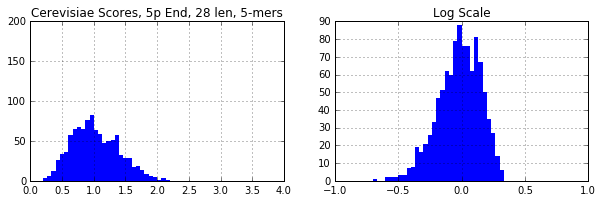

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import expon
import pandas as pd
import math
import time
import numpy as np
start_time = time.time()
plt.figure(1, figsize=(10, 20))

# cerevisiae 

plt.subplot(6,2,1)
plt.title('Cerevisiae Scores, 5p End, 28 len, 5-mers')
plt.grid(True)
plt.ylim(0.0, 200)
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_cerevisiae_28_5_5.csv")
content = df['score']
content = list(map(float, content))
plt.hist(content, bins=60, range=(0,4), edgecolor='none');

plt.subplot(6,2,2)
plt.title('Log Scale')
plt.grid(True)
#plt.gca().set_xscale("log")
s = np.random.normal(20, 10.0, 100)
df = pd.read_csv("norm_sqrt_cerevisiae_28_5_5.csv")
content = df['score']
content = list(map(float, content))
content = np.log10(content)
plt.hist(content, bins=60, range=(-1,1), edgecolor='none');
print(math.log10(10))
print(math.log10(0.1))

In [1]:
from notebook.auth import passwd
passwd()


Enter password: ········
Verify password: ········


'sha1:74bcd3d9b4f2:6f127f66e3d039f05f1cb0cecd7bfd7e41470521'